In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sd_cleaned = pd.read_csv('sd_cleaned.csv')

# Construction of a Fair Classifier in Search-to-Contraband-Finding Ratio

### Cheolmin Hwang

From the previous inspection of police stoppings in San Diego, I was able to observe significant discrepancies in the rates of contraband discovery upon search among different racial groups. From the simulation, It was shown that such a discrepancy was impossible to have happened from mere chance. By utilizing inframarginality and threshold testing, I will look deeper into the decision making of searches being decided to be conducted. I will also build a classifier that is more fair than the ones built on raw data from the insights I gain from these two methods that ensures fairness among different racial groups and the two sexes.

In continuation from the first assignment, we define search accuracy to be the rate that a contraband is found when a vehicle is searched, denoting how accurate the police's decision to decide to conduct a search in the first place was. Thus, we assume that the searches of the poice officers, or the standards that enforce them to search are supposed to indicate a contraband.

## Data Cleaning

First, since the focal point of fairness will be on the ratio of among the the vehicles that were searched how many vehicles were containing a contraband. Thus, we use the dataset that was cleaned in the same fashion when we examined for an inequality earlier. We eradicate all data points that do not consist of the driver's race, sex, whether or not a search was conducted, and whether or not a contraband was found.

In [3]:
sd = sd_cleaned.loc[sd_cleaned['subject_race'].notna()]
sd = sd.loc[sd['subject_sex'].notna()]
sd.isna().sum()

Unnamed: 0                         0
raw_row_number                     0
date                               0
time                              15
service_area                       0
subject_age                       68
subject_race                       0
subject_sex                        0
type                               0
arrest_made                       67
citation_issued                  734
warning_issued                   734
outcome                         2210
contraband_found                   0
search_conducted                   0
search_person                   2164
search_vehicle                  2164
search_basis                       0
reason_for_search               1984
reason_for_stop                    4
raw_action_taken                 734
raw_subject_race_description       0
dtype: int64

In [4]:
sd['subject_race'].unique()

array(['hispanic', 'black', 'white', 'asian/pacific islander', 'other'],
      dtype=object)

In [5]:
sd['subject_sex'].unique()

array(['male', 'female'], dtype=object)

In [6]:
sd['search_conducted'].unique()

array([ True])

In [7]:
sd.loc[sd['contraband_found'] == True].shape

(1545, 22)

In [8]:
sd['contraband_found'].unique()

array([ True, False])

We take a step further to include sex as a group dividing factor. Thus we divide the dataset into white male, white female, black male, black female, hispanic male, and hispanic female. We will examine the rates of search and the rates of contraband found among the searches. 

In [9]:
races = ['white', 'black', 'hispanic']
sexes = ['male', 'female']

labels = np.array([])
search_accuracies = np.array([])

for race in races:
    for sex in sexes:
        race_df = sd.loc[sd['subject_race'] == race]
        race_sex = race_df.loc[race_df['subject_sex'] == sex]
        row_search, col_search = race_sex.loc[race_sex['search_conducted'] == True].shape
        row_contra, col_contra = race_sex.loc[race_sex['contraband_found'] == True].shape
        search_accuracy = row_contra / row_search
        label = race + " " + sex
        search_accuracies = np.append(search_accuracies, search_accuracy)
        labels = np.append(labels, label)

In [10]:
pd.DataFrame(data={'search_accuracy': search_accuracies}, index=labels)

,search_accuracy
white male,0.119745
white female,0.099057
black male,0.093916
black female,0.089820
hispanic male,0.083616
hispanic female,0.070588


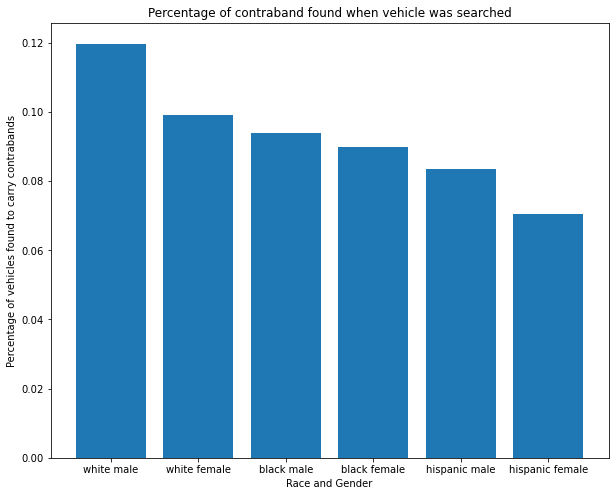

In [11]:
plt.figure(figsize=(10, 8))
plt.bar(labels, search_accuracies)
plt.title('Percentage of contraband found when vehicle was searched')
plt.xlabel('Race and Gender')
plt.ylabel('Percentage of vehicles found to carry contrabands')
plt.show()

## Model Construction
 
The model that I build will be a Random Forest Classifier. Depending on the values of the attributes/features, the classifier will predict whether or not the driver will have a contraband. From the above results, we can clearly see that searches on white male drivers lead to the highest rate of finding a contraband upon search. Thus, we assume that they show the traits that are mostly likely to hold a contraband.

We set the target variable (y) to be whether or not a contraband was found.
We set the features (X) to be the features/columns that are information of the drivers that the police know before the searching is conducted. However, regardless of the correlation level, the race and sex features of a driver will be exempt, since our original attempt is to build a fair classifier that does not discriminate against the race and sex features of a driver.

Thus, we use the variables: search basis, subject age, reason for stop, reason for search, service area.
We further drop all other variables because they are variables of actions taken after the search, or indirect descriptions of the driver's race, or are assigned numbers to datapoints that have no intuitive value.

Since there aren't as many blank holes in the age column, and there is a problem with filling them with dummy nans, empty age value data points will be dropped.

In [12]:

age_cleaned = sd[sd['subject_age'].notna()]
X = age_cleaned[['search_basis', 'subject_age', 'reason_for_stop', 'reason_for_search', 'service_area']]
y = age_cleaned['contraband_found']

In [13]:
X.isna().sum()

search_basis            0
subject_age             0
reason_for_stop         4
reason_for_search    1957
service_area            0
dtype: int64

In [14]:
X = X.fillna('na')

In [15]:
y.isna().sum()

0

Transform categorical features (which are all of them except for age) through one-hot encoding. Then train the Random Forest classifier on the transformed features.

In [16]:
features_to_encode = ['search_basis', 'reason_for_stop', 'reason_for_search', 'service_area']

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer((OneHotEncoder(),features_to_encode), remainder = "passthrough")

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(min_samples_leaf=50, n_estimators=150, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42, max_features='auto')

In [18]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(col_trans, rfc)
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['search_basis',
                                                   'reason_for_stop',
                                                   'reason_for_search',
                                                   'service_area'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=150,
                                        n_jobs=-1, oob_score=True,
                                        random_state=42))])

The classifier's accuracy on the overall population.

In [19]:
from sklearn.metrics import accuracy_score

predictions = pipe.predict(X)
accuracy_score(y, predictions)

0.9045999752689502

In [20]:
df = sd.copy()
df = df[df['subject_age'].notna()]
df = df.fillna('na')

rfc_labels = np.array([])
rfc_accuracy = np.array([])

for race in races:
    for sex in sexes:
        race_df = df.loc[df['subject_race'] == race]
        sex_df = race_df.loc[race_df['subject_sex'] == sex]
        sample_X = sex_df[['search_basis', 'subject_age', 'reason_for_stop', 'reason_for_search', 'service_area']]
        sample_y = sex_df['contraband_found']
        pred = pipe.predict(sample_X)
        label = race + " " + sex
        rfc_labels = np.append(rfc_labels, label)
        rfc_accuracy = np.append(rfc_accuracy, accuracy_score(sample_y, pred))

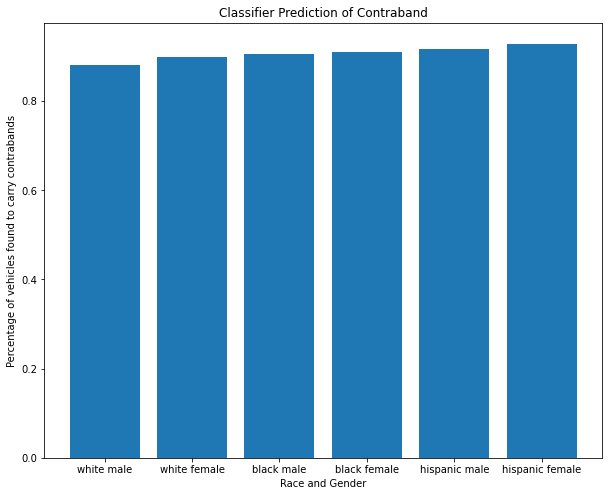

In [21]:
plt.figure(figsize=(10, 8))
plt.bar(rfc_labels, rfc_accuracy)
plt.title('Classifier Prediction of Contraband')
plt.xlabel('Race and Gender')
plt.ylabel('Percentage of vehicles found to carry contrabands')
plt.show()

From the initial results, we can see that the classifier has significantly better accuracy at predicting a contraband when compared to the standard procedures that police officers are enforced to search vehicles in prediction of a contraband.

## Individual Fairness

By implementing individual fairness mechanisms to the classifier, we wish to find out if the classifier is reliable enough to produce similar results for data points that input a similar feature set. It must be ensure that if people are being inspected due to probable cause or plain view, there should not be a difference in search results and accuracies by race and gender of the driver. Since the features used in the classifier are all categorical values, I will use the Jaccard similarity to measure the distances of the features and the outcomes.

It took way too long to compute the Jaccard similarity for the features of the entire dataset, so I will sample 1000.

In [74]:
# convert categorical values to numeric categories.

num_df = df.copy()
num_df['search_basis'] = num_df['search_basis'].replace({'probable cause': 4, 'other': 2, 'consent': 3, 'plain view': 5, 'k9': 1})
num_df['reason_for_stop'] = num_df['reason_for_stop'].replace({'Moving Violation': 1, 'Equipment Violation': 2,
       'Radio Call/Citizen Contact': 3, 'Personal Knowledge/Informant': 4,
       'Muni, County, H&S Code': 5, 'Suspect Info (I.S., Bulletin, Log)': 6,
       'Radio Call/Citizen Contact|Moving Violation': 3,
       'Equipment Violation|Equipment Violation|Moving Violation': 2,
       '&Moving Violation': 1, 'Suspect Info': 7, 'UNI, &County, H&&S Code': 5,
       'Equipment Violation|Moving Violation': 2,
       'Personal Observ/Knowledge': 7, 'na': 8, 'eEquipment Violation': 2, 'Other': 8,
       '&Equipment Violation': 2, 'No Cause Specified on a Card': 8,
       'Moving Violation|Suspect Info (I.S., Bulletin, Log)': 1,
       'NOT MARKED': 8, 'MUNI, County, H&S Code': 5,
       'Muni, County, H&S Code|Moving Violation': 5,
       'Moving Violation|Equipment Violation': 1})
num_df['service_area'] = num_df['service_area'].replace({'Unknown': 1, '310': 2, '810': 3, '320': 4, '240': 5, '830': 6, '820': 7, '440': 8, '110': 9,
       '120': 10, '430': 11, '610': 12, '620': 13, '930': 14, '720': 15, '710': 16, '510': 17, '520': 18,
       '230': 19, '630': 20, '530': 21, '840': 22, '130': 23})

In [78]:
sampled = num_df.sample(1000, random_state=42)

In [79]:
from scipy.spatial.distance import squareform, pdist, jaccard

dist = pdist(sampled[['search_basis', 'reason_for_stop', 'service_area']], jaccard)
squareform(dist)
jaccard = pd.DataFrame(1-squareform(dist))

In [80]:
jaccard

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.333333,0.333333,0.333333,0.333333,...,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.0,0.333333,0.333333
1,0.000000,1.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.333333,0.666667,0.333333,0.333333,0.0,0.000000,0.333333
2,0.333333,0.000000,1.000000,0.333333,0.333333,0.000000,0.333333,0.333333,0.333333,0.333333,...,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.0,0.333333,0.333333
3,0.333333,0.000000,0.333333,1.000000,0.333333,0.000000,0.333333,0.666667,0.666667,0.666667,...,0.333333,0.000000,0.666667,0.333333,0.000000,0.000000,0.666667,0.0,0.666667,0.333333
4,0.333333,0.333333,0.333333,0.333333,1.000000,0.333333,0.666667,0.333333,0.333333,0.333333,...,0.000000,0.000000,0.333333,0.666667,0.333333,0.333333,0.333333,0.0,0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.333333,0.000000,0.000000,0.333333,0.666667,0.333333,0.000000,0.333333,0.333333,...,0.333333,0.333333,0.000000,0.333333,0.333333,1.000000,0.000000,0.0,0.333333,0.333333
996,0.333333,0.333333,0.333333,0.666667,0.333333,0.000000,0.333333,0.666667,0.666667,0.666667,...,0.333333,0.000000,0.666667,0.333333,0.000000,0.000000,1.000000,0.0,0.666667,0.333333
997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
998,0.333333,0.000000,0.333333,0.666667,0.333333,0.000000,0.333333,0.666667,1.000000,1.000000,...,0.333333,0.000000,0.666667,0.333333,0.000000,0.333333,0.666667,0.0,1.000000,0.333333


In [86]:
n = 1000
columns = jaccard.columns
indices = jaccard.index
lists = []

for i in range(1, n):
    index = indices[i]
    matr = jaccard[index][:i]
    for j in range(i):
        column = columns[j]
        value = matr[column]
        lst = [index, column, value]
        lists.append(lst)

df_jac = pd.DataFrame(lists)
df_jac_df = df_jac.rename(columns={0:"instance 1", 1:"instance 2", 2:"jaccard"})
df_jac

,0,1,2
0,1,0,0.000000
1,2,0,0.333333
2,2,1,0.000000
3,3,0,0.333333
4,3,1,0.000000
...,...,...,...
499495,999,994,0.333333
499496,999,995,0.333333
499497,999,996,0.333333
499498,999,997,0.000000


In [100]:
same_outcome = 0
diff_outcome = 0
for index in range(0, len(df_jac)):
    similarity = df_jac.iloc[index][2]
    first_index = int(df_jac.iloc[index][0])
    second_index = int(df_jac.iloc[index][1])
    if similarity == 1.0:
        if sampled.iloc[first_index]['contraband_found'] == sampled.iloc[second_index]['contraband_found']:
            same_outcome = same_outcome + 1
        else:
            diff_outcome = diff_outcome + 1

In [101]:
same_outcome, diff_outcome

(5773, 1029)

As we can see, out of the 6082 pairs that were considered similar, a thousand of them proved to be wrong, and over 5700 produced similar results from the similar categorical features. This is probably due to the low rate of frequency of the target variable, as contraband discovery rates are too low. Furthermore, there is potential reason in the dataset's features that they do not really describe how the police officers arrived at their decision. Only a few features indicate some aspects officers that may have been taken into consideration by the officers, but most of them are about what the actions taken by the officer was. So it is hard to produce a fair classifier for a target on the behavior of the driver.

## Intersectionality

As previously shown in the first graph, we were able to observe from the data that searches on balck and hispanic drivers had lower rates of contraband found upon search when compared to white drivers. This meant that many more hispanic and black drivers had to go through unecessary searches. Thus, we will see if our classifier has made fair predictions for each racial group. Furthermore, We test the classifier for its accuracy on other racial and gender groups. For this analysis on intersectionality, we will take a look at the topic of search basis and its relationship with race and gender. This will be exploring if a type of search basis have a relationship with a subgroup. We will compare its itersectionality from the original dataset, and that from the predictions made by the classifier.

In [53]:
search_bases = np.array(['probable cause', 'other', 'consent', 'plain view', 'k9'])
labels = np.array([])
accs = np.array([])

for race in races:
    for sex in sexes:
        label = race + " " + sex
        labels = np.append(labels, label)
        print()
        row = np.array([])
        for base in search_bases:
            race_df = df.loc[df['subject_race'] == race]
            sex_df = race_df.loc[race_df['subject_sex'] == sex]
            base_df = sex_df.loc[sex_df['search_basis'] == base]
            row_search, col_search = base_df.loc[base_df['search_conducted'] == True].shape
            row_contra, col_contra = base_df.loc[base_df['contraband_found'] == True].shape
            search_accuracy = 0
            if row_contra != 0:
                search_accuracy = row_contra / row_search
            row = np.append(row, search_accuracy)
        accs = np.append(accs, row)

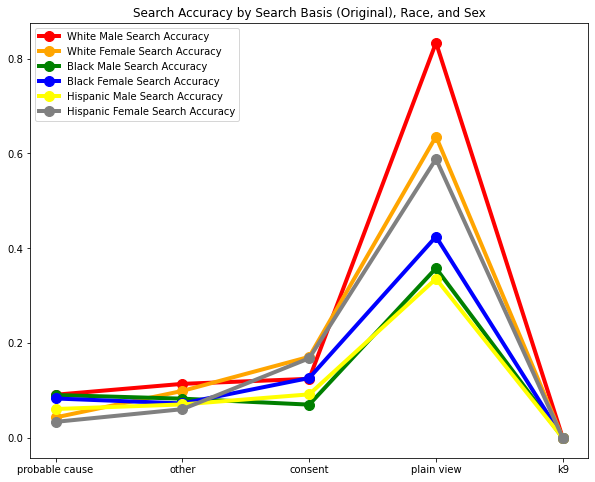

In [57]:
original_inter = pd.DataFrame(list(zip(search_bases, accs[0:5], accs[5:10], accs[10:15], accs[15:20], accs[20:25], accs[25:30])),
columns = ['Search Basis', 'White Male Search Accuracy', 'White Female Search Accuracy', 'Black Male Search Accuracy', 'Black Female Search Accuracy', 'Hispanic Male Search Accuracy', 'Hispanic Female Search Accuracy'])

plt.figure(figsize=(10, 8))

plt.plot('Search Basis', 'White Male Search Accuracy', data=original_inter, marker='o', markerfacecolor='red', markersize=10, color='red', linewidth=4)
plt.plot('Search Basis', 'White Female Search Accuracy', data=original_inter, marker='o', markerfacecolor='orange', markersize=10, color='orange', linewidth=4)
plt.plot('Search Basis', 'Black Male Search Accuracy', data=original_inter, marker='o', markerfacecolor='green', markersize = 10, color='green', linewidth=4)
plt.plot('Search Basis', 'Black Female Search Accuracy', data=original_inter, marker='o', markerfacecolor='blue', markersize=10, color='blue', linewidth=4)
plt.plot('Search Basis', 'Hispanic Male Search Accuracy', data=original_inter, marker='o', markerfacecolor='yellow', markersize = 10, color='yellow', linewidth=4)
plt.plot('Search Basis', 'Hispanic Female Search Accuracy', data=original_inter, marker='o', markerfacecolor='gray', markersize=10, color='gray', linewidth=4)

plt.legend()
plt.title('Search Accuracy by Search Basis (Original), Race, and Sex')
plt.show()

In [24]:
df['contraband_prediction'] = predictions

In [25]:
search_bases = np.array(['probable cause', 'other', 'consent', 'plain view', 'k9'])
labels = np.array([])
sim_accs = np.array([])

for race in races:
    for sex in sexes:
        label = race + " " + sex
        labels = np.append(labels, label)
        print()
        row = np.array([])
        for base in search_bases:
            race_df = df.loc[df['subject_race'] == race]
            sex_df = race_df.loc[race_df['subject_sex'] == sex]
            base_df = sex_df.loc[sex_df['search_basis'] == base]
            row_search, col_search = base_df.loc[base_df['search_conducted'] == True].shape
            row_contra, col_contra = base_df.loc[base_df['contraband_prediction'] == True].shape
            search_accuracy = 0
            if row_contra != 0:
                search_accuracy = row_contra / row_search
            row = np.append(row, search_accuracy)
        sim_accs = np.append(sim_accs, row)

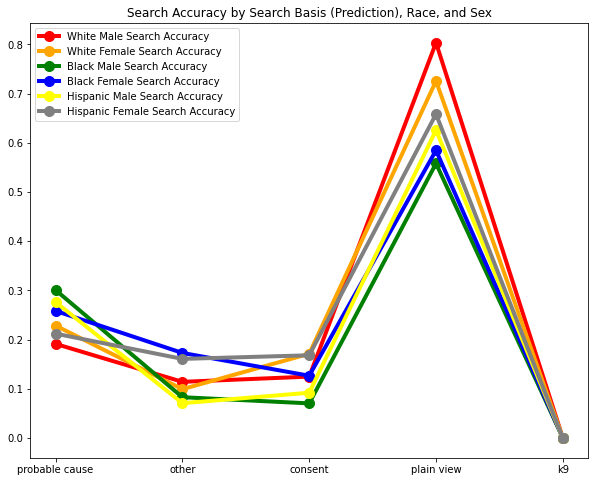

In [63]:
classifier_inter = pd.DataFrame(list(zip(search_bases, sim_accs[0:5], sim_accs[5:10], sim_accs[10:15], sim_accs[15:20], sim_accs[20:25], sim_accs[25:30])),
columns = ['Search Basis', 'White Male Search Accuracy', 'White Female Search Accuracy', 'Black Male Search Accuracy', 'Black Female Search Accuracy', 'Hispanic Male Search Accuracy', 'Hispanic Female Search Accuracy'])

plt.figure(figsize=(10, 8))

plt.plot('Search Basis', 'White Male Search Accuracy', data=classifier_inter, marker='o', markerfacecolor='red', markersize=10, color='red', linewidth=4)
plt.plot('Search Basis', 'White Female Search Accuracy', data=classifier_inter, marker='o', markerfacecolor='orange', markersize=10, color='orange', linewidth=4)
plt.plot('Search Basis', 'Black Male Search Accuracy', data=classifier_inter, marker='o', markerfacecolor='green', markersize = 10, color='green', linewidth=4)
plt.plot('Search Basis', 'Black Female Search Accuracy', data=classifier_inter, marker='o', markerfacecolor='blue', markersize=10, color='blue', linewidth=4)
plt.plot('Search Basis', 'Hispanic Male Search Accuracy', data=classifier_inter, marker='o', markerfacecolor='yellow', markersize = 10, color='yellow', linewidth=4)
plt.plot('Search Basis', 'Hispanic Female Search Accuracy', data=classifier_inter, marker='o', markerfacecolor='gray', markersize=10, color='gray', linewidth=4)

plt.legend()
plt.title('Search Accuracy by Search Basis (Prediction), Race, and Sex')
plt.show()

When looking at the intersectionality of search basis upon race and sex, it can easily be observed that most searches that are conducted on the basis of plain view, which is very subjective and may differ in standards among different police officers, is the most accurate in searches leading to contraband discoveries. However, we can clearly see the racial discrepancy in search accuracy between white drivers and the drivers of the other two races. It can be clearly seen that searches based on plain view on black males and females, and hispanic males show a significantly lower accuracy. (Please disregard the k9 search basis type as the data consists of no data points that have the k9 type.)

From the results that predicted the contrabands by the classifier, we can easily observe that although the raical discrepancies in the search accuracies are clearn, the search accuracies based on plain view on black and hispanic drivers increased significantly upto approximately 0.6.

One intereting tendency in sex that we found was that searches on female drivers tended to be more accurate, and only white drivers were the exception: as searches on white males still prove to be the most accurate in both reality and in preidictions.